In [98]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [99]:
class mCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < minMAE):
            self.model.stop_training = True
            print("Done =====> MAE of the model < 10% of data scale")

In [100]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [101]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [102]:
dataset = pd.read_csv('dataset/GlobalTemperatures.csv')
dataset.isnull().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [103]:
dataset.dropna(axis='rows', inplace=True)
dates = dataset['dt']
rain = dataset['LandAverageTemperature']

In [104]:
dataset[['dt', 'LandAverageTemperature']].tail(10)

,dt,LandAverageTemperature
3182,2015-03-01,6.740
3183,2015-04-01,9.313
3184,2015-05-01,12.312
3185,2015-06-01,14.505
3186,2015-07-01,15.051
3187,2015-08-01,14.755
3188,2015-09-01,12.999
3189,2015-10-01,10.801
3190,2015-11-01,7.433
3191,2015-12-01,5.518


In [105]:
minMAE = (dataset['LandAverageTemperature'].max() - dataset['LandAverageTemperature'].min()) * (10/100)
minMAE

1.5078

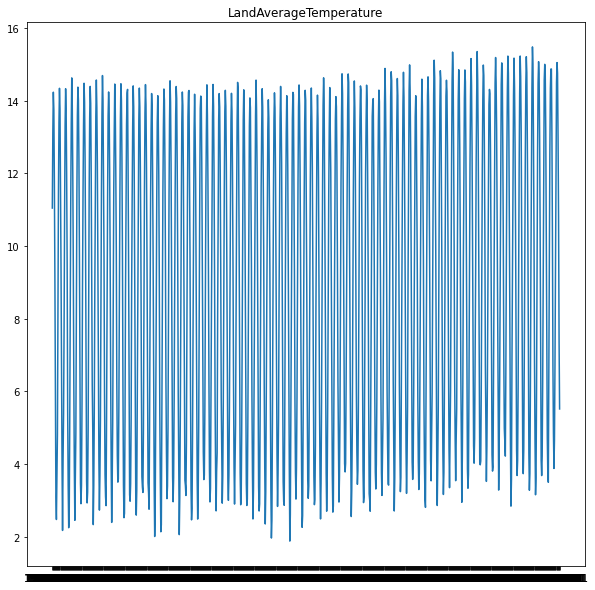

In [106]:
plt.figure(figsize=(10, 10))
plt.plot(dates[1000:], rain[1000:])
plt.title('LandAverageTemperature')
plt.show()

In [107]:
X_train, X_test, y_train, y_test = train_test_split(rain, dates, test_size=0.2)

In [118]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 64
batch_size = 256
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
validation_set = windowed_dataset(X_test, window_size, batch_size, shuffle_buffer_size)

In [119]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
callback = mCallback()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [120]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
train = model.fit(train_set,epochs=100, callbacks=[callback], validation_data=validation_set)

Epoch 1/100
6/6 [==============================] - 8s 504ms/step - loss: 32.6788 - mae: 33.1750 - val_loss: 49.4446 - val_mae: 49.9446
Epoch 2/100
6/6 [==============================] - 2s 266ms/step - loss: 30.6374 - mae: 31.1320 - val_loss: 9.8129 - val_mae: 10.3128
Epoch 3/100
6/6 [==============================] - 2s 267ms/step - loss: 8.0557 - mae: 8.5462 - val_loss: 11.0089 - val_mae: 11.5076
Epoch 4/100
6/6 [==============================] - 2s 271ms/step - loss: 9.8194 - mae: 10.3104 - val_loss: 3.5881 - val_mae: 4.0727
Epoch 5/100
6/6 [==============================] - 2s 273ms/step - loss: 8.8479 - mae: 9.3409 - val_loss: 16.8335 - val_mae: 17.3335
Epoch 6/100
6/6 [==============================] - 2s 275ms/step - loss: 14.9881 - mae: 15.4838 - val_loss: 19.7491 - val_mae: 20.2491
Epoch 7/100
6/6 [==============================] - 2s 277ms/step - loss: 19.8411 - mae: 20.3386 - val_loss: 3.5490 - val_mae: 4.0201
Epoch 8/100
6/6 [==============================] - 2s 272ms/step 

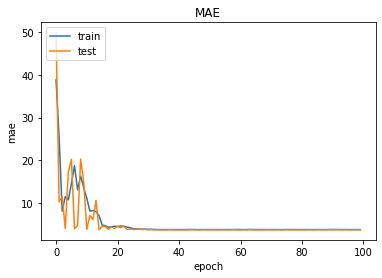

In [121]:
plt.plot(train.history['mae'])
plt.plot(train.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

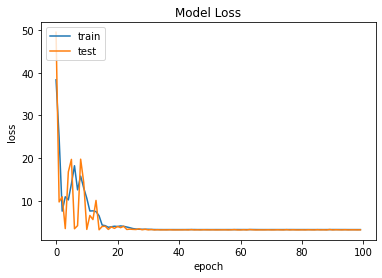

In [122]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()